# Problem Statement
In Toronto, many families choose to become an Airbnb host to compensate their realty mortgage cost. When searching for a cozy temporary home, people choose hosts based on a variety of reasons, for example hosts with most reviews, beautiful staging pictures, reasonable prices and much more. However, not every host is good at promoting their homes, or they can be inexperienced at hospitality that drives their reviews down and hurt their revenue. Our project aims to help those bottoms of the list stay afloat in Airbnb business, finding what are possible factors driving their occupancy rate and review scores.  
# Data
### Key Variables
**Listing features**: First date since host went live, Response time range, Response percentage, Airbnb authorized superhost, # of listing owned by host, Types of verification needed from guests, if host has profile picture, if host identity is verified, neighborhood, location, property type, room type, default number of guests, # of bathrooms, # of bedrooms, # of beds, bed type, amenities, price, cleaning fee, fee for extra people, minimum and maximum nights, cancellation policy, if require guest picture, if require guest phone verification.

**Review features**: Total number of reviews, last review date, review score rating, accuracy score, cleanliness score, check-in score, communication score, location score, value score, if instant bookable.

**Target variable**: Occupancy index = Reviews per month * Review score rating.

Airbnb as a “Sharing Economy” company scrapes their own database of reviews, listings and calendars on a monthly basis, and posted on Inside Airbnb (insideairbnb.com). We will focus on listing data which contains up-to-date review scores, review counts and hosts’ listing features. From there, we can study what is actually impacting listing popularity and scores. 

However occupancy is not provided in the dataset due to privacy reasons, we chose to create an indicator of reviews per month * review scores rating. Although reviews per month does not equals to occupancy rate, but it is still an indicator of the listing popularity. 
# Methods
After feature engineering including one-hot encoding on categorical variables and nested-lists, we have more than 400 features created for this model. To avoid overfitting and multicollinearity, we used L1, L2 and Elastic Net regression for variable selection and obtain feature importance. For loss function, we chose Rooted Mean Squared Error (RMSE) because it is widely used in regression. And then we will move on to more robust modeling methods such as decision tree, random forest and xgboost, etc. We could move back to data engineering to create more features or find more outside data to support our model.


## Loading data and data engineering

In [744]:
import pandas as pd
import numpy as np
import ast
from decimal import Decimal
from datetime import timedelta, datetime
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib
import matplotlib.pyplot as plt

In [745]:
listing = pd.read_csv('listings.csv', index_col = "id", low_memory = False)

In [746]:
listing.head()

,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,
1419,https://www.airbnb.com/rooms/1419,20181206023116,2018-12-06,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",...,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.17
8077,https://www.airbnb.com/rooms/8077,20181206023116,2018-12-06,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,...,f,NaN,NaN,t,f,strict_14_with_grace_period,f,t,2,1.50
10314,https://www.airbnb.com/rooms/10314,20181206023116,2018-12-06,Union Inn II (Leslieville),We offer a private room for two with a queen b...,"The 'union inn' offers a clean, spacious room ...",We offer a private room for two with a queen b...,none,Our charming adopted home of Leslieville is a ...,"Clean towels, a hair dryer, soap and sanitary ...",...,f,NaN,NaN,f,f,moderate,f,f,1,0.68
12604,https://www.airbnb.com/rooms/12604,20181206023116,2018-12-06,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlour.,Family of 4 (2 kids) plus a friendly dog open...,Comfortable sofa bed in airy main floor parlou...,none,NaN,NaN,...,f,NaN,NaN,f,f,moderate,f,f,1,NaN
23691,https://www.airbnb.com/rooms/23691,20181206023116,2018-12-06,Queen Bedroom close to downtown,NaN,Nestled in the middle of a quiet residential n...,Nestled in the middle of a quiet residential n...,none,NaN,* Laundry facilities are available at the prem...,...,f,NaN,NaN,t,f,strict_14_with_grace_period,f,f,2,1.99


## Cherry pick valueble independent variables
| colname                          | description                         |
|----------------------------------|-------------------------------------|
| host_since                       | First date since host went live     |
| host_response_time               | Response time range                 |
| host_response_rate               | Response percentage                 |
| host_is_superhost                | Airbnb authorized superhost T/F     |
| host_listings_count              | # of listing owned by host          |
| host_verifications               | Types of verification needed from guests        |
| host_has_profile_pic             | T/F                                 |
| host_identity_verified           | T/F                                 |
| neighbourhood_cleansed           | Sub-region of Toronto               |
| smart_location                   | Cleaned city location               |
| is_location_exact                | T/F                                 |
| property_type                    | House/Condo/etc                     |
| room_type                        | Private/Share                       |
| accommodates                     | max guests                          |
| bathrooms                        | # of bathrooms                      |
| bedrooms                         | # of bedrooms                       |
| beds                             | # of beds                           |
| bed_type                         | bed/sofa/etc                        |
| amenities                        | TV/internet/etc                     |
| price                            | One-day price                       |
| weekly_price                     |                                     |
| monthly_price                    |                                     |
| security_deposit                 |                                     |
| cleaning_fee                     |                                     |
| guests_included                  | default allowed guest number        |
| extra_people                     | cost of additional people per night |
| minimum_nights                   |                                     |
| maximum_nights                   |                                     |
| number_of_reviews                | Total number of reviews             |
| last_review                      | Date of latest review               |
| review_scores_rating             | 0-100                               |
| review_scores_accuracy           | 2-10                                |
| review_scores_cleanliness        | 2-10                                |
| review_scores_checkin            | 2-10                                |
| review_scores_communication      | 2-10                                |
| review_scores_location           | 2-10                                |
| review_scores_value              | 2-10                                |
| instant_bookable                 | T/F                                 |
| cancellation_policy              | moderate/strict/etc                 |
| require_guest_profile_picture    | T/F                                 |
| require_guest_phone_verification | T/F                                 |
| reviews_per_month                | 0-30                                |

In [747]:
sub_colnames = ['host_since', 'host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'smart_location', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 'require_guest_phone_verification', 'reviews_per_month']

In [748]:
Airbnb = listing[sub_colnames]
print('Total Rows:', Airbnb.shape[0])

Total Rows: 19255


In [749]:
# Drop NA
Airbnb = Airbnb.dropna(subset = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'reviews_per_month', 'review_scores_rating'])
print('Total Rows After Dropping NA:', Airbnb.shape[0])

Total Rows After Dropping NA: 9447


### Basic Data Cleaning
Turn percentage to float and turn Ture/False to 1 or 0

In [750]:
# Percentage to float
Airbnb['host_response_rate'] = Airbnb.host_response_rate.str.rstrip('%').astype('float')
# True or False to 1 or 0
Airbnb[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']] = Airbnb[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact', 'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']].eq('t').mul(1)

In [751]:
# Convert currency to float
Airbnb['price'] = pd.to_numeric(Airbnb['price'].str.lstrip('$').str.replace(",",""))
Airbnb['weekly_price'] = pd.to_numeric(Airbnb['weekly_price'].str.lstrip('$').str.replace(",",""))
Airbnb['monthly_price'] = pd.to_numeric(Airbnb['monthly_price'].str.lstrip('$').str.replace(",",""))
Airbnb['security_deposit'] = pd.to_numeric(Airbnb['security_deposit'].str.lstrip('$').str.replace(",",""))
Airbnb['cleaning_fee'] = pd.to_numeric(Airbnb['cleaning_fee'].str.lstrip('$').str.replace(",",""))
Airbnb['extra_people'] = pd.to_numeric(Airbnb['extra_people'].str.lstrip('$').str.replace(",",""))

In [752]:
Airbnb['weekly_price'].fillna(Airbnb['price']*7, inplace = True)
Airbnb['monthly_price'].fillna(Airbnb['price']*30, inplace = True)
Airbnb['security_deposit'].fillna(0, inplace = True)
Airbnb['cleaning_fee'].fillna(0, inplace = True)

### Turn host_since to length of years of hosting and last_review to length of months

In [753]:
Airbnb['host_since'] = pd.to_datetime(Airbnb['host_since'], format = '%Y-%m-%d')
Airbnb['host_years'] = (datetime.strptime('2018-12-06', '%Y-%m-%d') - Airbnb['host_since']) / timedelta(days = 365)
Airbnb.drop(columns = 'host_since', axis = 1, inplace = True)

In [754]:
Airbnb['last_review'] = pd.to_datetime(Airbnb['last_review'], format = '%Y-%m-%d')
Airbnb['months_since_last_review'] = (datetime.strptime('2018-12-06', '%Y-%m-%d') - Airbnb['last_review']) / timedelta(days = 30)
Airbnb.drop(columns = 'last_review', axis = 1, inplace = True)

### One-hot encoding for nested lists: host_verifications and amenities
```
https://stackoverflow.com/questions/45312377/how-to-one-hot-encode-from-a-pandas-column-containing-a-list
```

In [755]:
mlb = MultiLabelBinarizer()
Airbnb['host_verifications'] = Airbnb['host_verifications'].apply(ast.literal_eval)
Airbnb = Airbnb.join(pd.DataFrame(mlb.fit_transform(Airbnb.pop('host_verifications')),
                          columns=mlb.classes_,
                          index=Airbnb.index))

In [756]:
# Formatting
Airbnb['amenities'] = Airbnb['amenities'].str.replace("{","")
Airbnb['amenities'] = Airbnb['amenities'].str.replace("}","")
Airbnb['amenities'] = Airbnb['amenities'].str.replace('"', '')
Airbnb['amenities'] = Airbnb['amenities'].str.replace(" ", "")
Airbnb['amenities'] = Airbnb['amenities'].str.replace(',', ' ')
Airbnb['amenities'] = Airbnb['amenities'].str.split()
Airbnb['amenities_count'] = Airbnb['amenities'].apply(len)

In [757]:
mlb = MultiLabelBinarizer()
Airbnb = Airbnb.join(pd.DataFrame(mlb.fit_transform(Airbnb.pop('amenities')),
                          columns=mlb.classes_,
                          index=Airbnb.index))

### One-hot encoding for categorical data

In [758]:
Airbnb = pd.get_dummies(Airbnb, prefix = ['host_response_time','neighbourhood','smart_location','property_type','room_type', 'bed_type', 'cancellation_policy'], columns = ['host_response_time','neighbourhood_cleansed','smart_location','property_type', 'room_type', 'bed_type', 'cancellation_policy'])

### Adding price_per_guest attribute into Airbnb

In [759]:
Airbnb['price_per_guest'] = Airbnb['price'] / Airbnb['guests_included']
Airbnb.drop('price', axis = 1, inplace = True)

### Adding Occupancy_index as target variable

In [760]:
Airbnb['Occupancy_index'] = Airbnb['reviews_per_month'] * Airbnb['review_scores_rating']
Airbnb.drop(['reviews_per_month', 'review_scores_rating'], axis = 1, inplace = True)

In [761]:
listing['Occupancy_index'] = listing['reviews_per_month'] * listing['review_scores_rating']

## Exploring the data
visualize the data with a histogram.

In [762]:
listing = listing.loc[Airbnb.index]

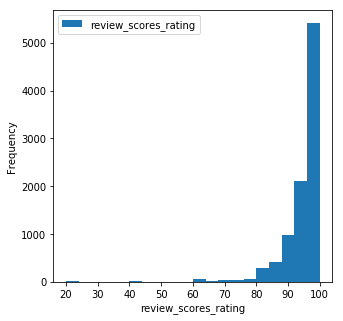

In [763]:
listing[['review_scores_rating']].plot.hist(bins=20)
plt.xlabel('review_scores_rating');

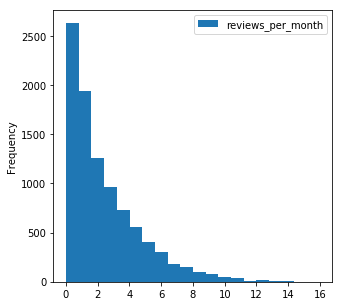

In [764]:
listing[['reviews_per_month']].plot.hist(bins=20)

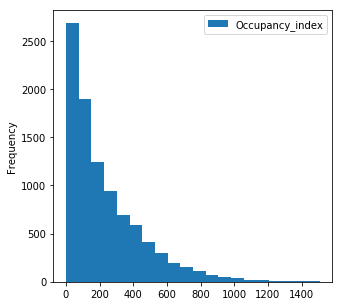

In [765]:
listing[['Occupancy_index']].plot.hist(bins=20)

Create a figure with boxplot that display the distribution of mean squared error and r-squared values.

535.5359999999998

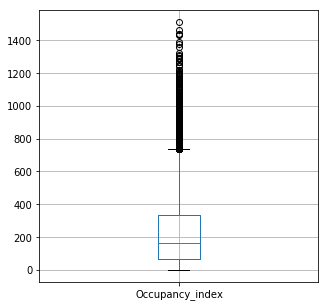

In [766]:
listing.boxplot(column='Occupancy_index')
listing['Occupancy_index'].quantile(0.9)

0.71

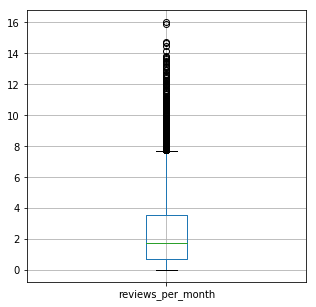

In [767]:
listing.boxplot(column='reviews_per_month')
listing['reviews_per_month'].quantile(0.25)

In [768]:
listing['price'] = pd.to_numeric(listing['price'].str.lstrip('$').str.replace(",",""))
listing['price_per_guest'] = listing['price'] / listing['guests_included']

In [769]:
low_occupancy_listing = listing[listing['Occupancy_index'] < 65.66000000000001]
high_occupancy_listing = listing[listing['Occupancy_index'] > 535.5359999999998]

In [770]:
low_occupancy = low_occupancy_listing[['property_type', 'Occupancy_index']].groupby(['property_type']).count().sort_values(by = ['Occupancy_index'], ascending = False)
high_occupancy = high_occupancy_listing[['property_type', 'Occupancy_index']].groupby(['property_type']).count().sort_values(by = ['Occupancy_index'], ascending = False)

In [771]:
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go

High_Occupancy = go.Bar(
    x=high_occupancy.index.values,
    y=high_occupancy.Occupancy_index.values,
    name = 'High Occupancy'
)

Low_Occupancy = go.Bar(
    x=low_occupancy.index.values,
    y=low_occupancy.Occupancy_index.values,
    xaxis='x2',
    yaxis='y2',
    name = 'Low Occupancy'
)


data = [High_Occupancy, Low_Occupancy]

layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 1]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    yaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    )
)

fig = go.Figure(data=data, layout=layout)
fig['layout'].update(title='High Occupancy vs Low Occupancy by Property Type')
py.iplot(fig, filename='text-hover-bar')

In [772]:
High_Occupancy = go.Histogram(
    x=high_occupancy_listing['price_per_guest'].values,
    nbinsx = 30,
    name = 'High Occupancy'
)

Low_Occupancy = go.Histogram(
    x=low_occupancy_listing['price_per_guest'].values,
    xaxis='x2',
    yaxis='y2',
    nbinsx = 30,
    name = 'Low Occupancy'
)


data = [High_Occupancy, Low_Occupancy]

layout = go.Layout(
    xaxis=dict(
        domain=[0, 0.45]
    ),
    yaxis=dict(
        domain=[0, 1]
    ),
    xaxis2=dict(
        domain=[0.55, 1]
    ),
    yaxis2=dict(
        domain=[0, 1],
        anchor='x2'
    )
)

fig = go.Figure(data=data, layout=layout)
fig['layout'].update(title='High Occupancy vs Low Occupancy by Property Type')
py.iplot(fig, filename='text-hover-bar')

## Use Lasso, Ridge and ElasticNet for variable selection

In [773]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [774]:
Airbnb.fillna(0, inplace = True)
y = Airbnb['Occupancy_index']
X = Airbnb.drop('Occupancy_index', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [775]:
ridge = Ridge()
ridge.fit(X, y)
model = SelectFromModel(ridge, prefit=True)
X_new = model.transform(X)

feature_idx = model.get_support()
ridge_feature_name = X.columns[feature_idx]

E:\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.287069e-20



In [776]:
lasso = Lasso()
lasso.fit(X, y)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X)
feature_idx = model.get_support()
lasso_feature_name = X.columns[feature_idx]

In [777]:
elastic = ElasticNet()
elastic.fit(X, y)
model = SelectFromModel(elastic, prefit=True)
X_new = model.transform(X)
feature_idx = model.get_support()
elasticnet_feature_name = X.columns[feature_idx]

In [778]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [779]:
rtree = DecisionTreeRegressor()
rmse = np.sqrt(-np.mean(cross_val_score(rtree, X, y, scoring = 'neg_mean_squared_error', cv=10)))
print('RMSE:{}'.format(rmse))

RMSE:207.7839288482635


In [780]:
rtree = DecisionTreeRegressor()
rmse = np.sqrt(-np.mean(cross_val_score(rtree, X[lasso_feature_name ], y, scoring = 'neg_mean_squared_error', cv=10)))
print('lasso RMSE:{}'.format(rmse))

lasso RMSE:204.0569668727036


In [781]:
rtree = DecisionTreeRegressor()
rmse = np.sqrt(-np.mean(cross_val_score(rtree, X[ridge_feature_name], y, scoring = 'neg_mean_squared_error', cv=10)))
print('ridge RMSE:{}'.format(rmse))

ridge RMSE:216.92362095347576


In [782]:
rtree = DecisionTreeRegressor()
rmse = np.sqrt(-np.mean(cross_val_score(rtree, X[elasticnet_feature_name], y, scoring = 'neg_mean_squared_error', cv=10)))
print('elasticnet RMSE:{}'.format(rmse))

elasticnet RMSE:221.99969748100045


### Lasso Regression score the best!
#### Feature Importance

In [783]:
rtree = DecisionTreeRegressor()
rtree.fit(X[lasso_feature_name], y)
Feature_importance = pd.DataFrame({'feature_name':lasso_feature_name.values, 'feature_importance':rtree.feature_importances_})
Feature_importance.nlargest(5, 'feature_importance')

,feature_name,feature_importance
22,months_since_last_review,0.393602
15,minimum_nights,0.081819
12,cleaning_fee,0.043016
2,host_listings_count,0.035924
21,host_years,0.034954


In [786]:
from sklearn import tree
tree.export_graphviz(rtree, out_file='tree.dot', max_depth = 2, feature_names = lasso_feature_name.values)

In [663]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [684]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 1, learning_rate = 0.45,
                max_depth = 300, alpha = 10, n_estimators = 15)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
rmse

157.79654056944779

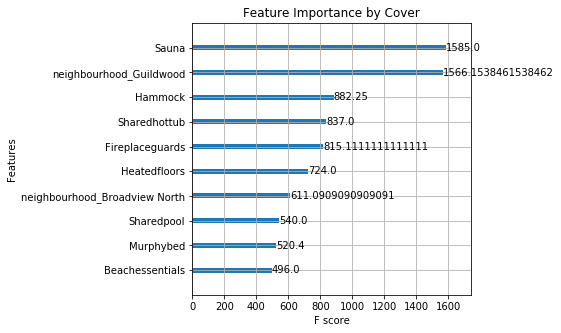

In [787]:
xgb.plot_importance(xg_reg, max_num_features=10, importance_type='cover', title = "Feature Importance by Cover")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

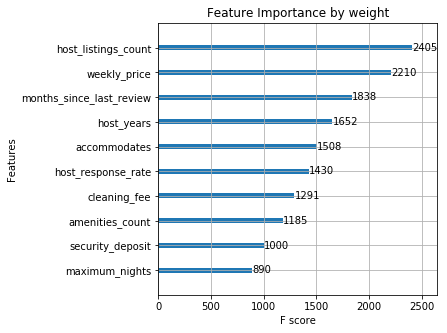

In [788]:
xgb.plot_importance(xg_reg, max_num_features=10, importance_type='weight', title = "Feature Importance by weight")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()